**1. Colab does not have the library PyPortfolioOpt,Shimmy and stable_baseline so we install them**

In [ ]:
!pip install 'shimmy>=0.2.1'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 15.5 MB/s eta 0:00:00


In [ ]:
!pip install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
pip install git+https://github.com/robertmartin8/PyPortfolioOpt.git

  Cloning https://github.com/robertmartin8/PyPortfolioOpt.git to /tmp/pip-req-build-y_5v4aeo
  Running command git clone --filter=blob:none --quiet https://github.com/robertmartin8/PyPortfolioOpt.git /tmp/pip-req-build-y_5v4aeo
  Resolved https://github.com/robertmartin8/PyPortfolioOpt.git to commit 46f84850febb73a0fa1811114adffe27bde91f08
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyportfolioopt: filename=pyportfolioopt-1.5.5-py3-none-any.whl size=61900 sha256=3c34c10f5499674a5297a6b91072288495e5f43a81547b3cc52595ee5c865793
  Stored in directory: /tmp/pip-ephem-wheel-cache-qkcwod05/wheels/82/e2/33/c00989e8bf211fc28b66524f439f00af4428d28db1c3bb8dbe
Successfully built pyportfolioopt


**1b. We import required libraries**

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
import gym
from gym import spaces
from itertools import combinations
from collections import OrderedDict
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


/usr/local/lib/python3.10/dist-packages/pypfopt/plotting.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-deep")


**2. We start by selecting 5 optimal assets to build the portfolio from 15 selected assets.**

[*********************100%%**********************]  15 of 15 completed


Discrete allocation:
OrderedDict([('INTC', 12), ('MA', 7), ('UNH', 4)])
Expected annual return: 51.1%
Annual volatility: 34.9%
Sharpe Ratio: 1.41

Covariance Matrix for All Assets:
Ticker      AAPL      AMZN      GOOG        HD      INTC       JNJ       JPM  \
Ticker                                                                         
AAPL    0.084324  0.054972  0.051678  0.037654  0.051861  0.019914  0.035967   
AMZN    0.054972  0.110670  0.062523  0.035056  0.047055  0.015116  0.027555   
GOOG    0.051678  0.062523  0.081754  0.034988  0.048019  0.018200  0.034120   
HD      0.037654  0.035056  0.034988  0.061295  0.039991  0.018774  0.036153   
INTC    0.051861  0.047055  0.048019  0.039991  0.111970  0.020810  0.041940   
JNJ     0.019914  0.015116  0.018200  0.018774  0.020810  0.033677  0.021164   
JPM     0.035967  0.027555  0.034120  0.036153  0.041940  0.021164  0.077114   
MA      0.048541  0.045135  0.046950  0.037899  0.046560  0.021713  0.045590   
META    0.060289  0

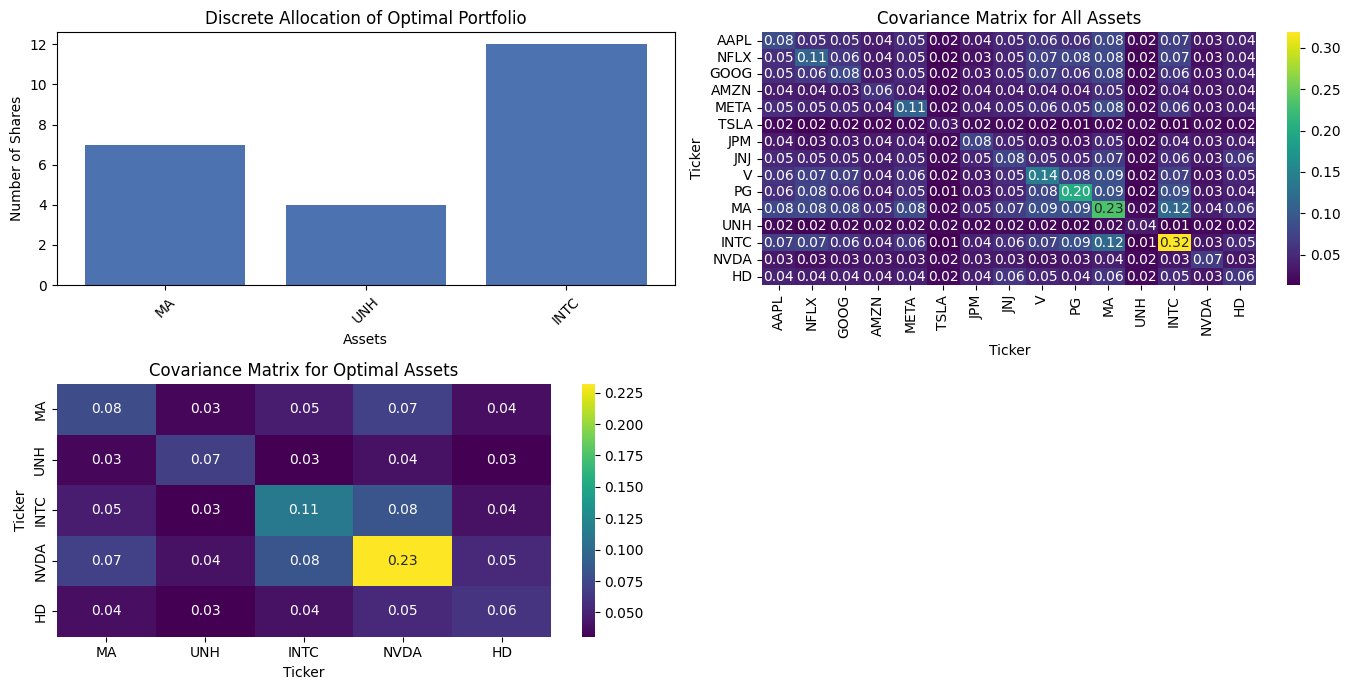

In [ ]:

# Define the tickers
tickers = ['AAPL', 'NFLX', 'GOOG', 'AMZN', 'META', 'TSLA', 'JPM', 'JNJ', 'V', 'PG',
           'MA', 'UNH', 'INTC', 'NVDA', 'HD']

# Download historical data from Yahoo Finance
stock_data = yf.download(tickers, start='2015-01-01', end='2024-01-01')['Adj Close']

# Calculate the covariance matrix for all 15 assets
cov_matrix_all_assets = risk_models.sample_cov(stock_data)

# Initialize variables to store optimal portfolio
optimal_weights = None
max_sharpe = -np.inf

# Iterate through all combinations of 5 assets
for assets in combinations(tickers, 5):
    selected_stock_data = stock_data[list(assets)]
    mu = expected_returns.mean_historical_return(selected_stock_data)
    Sigma = risk_models.sample_cov(selected_stock_data)
    ef = EfficientFrontier(mu, Sigma)
    weights = ef.max_sharpe()
    sharpe_ratio = ef.portfolio_performance()[2]
    if sharpe_ratio > max_sharpe:
        max_sharpe = sharpe_ratio
        optimal_weights = weights

# Clean weights to allocate them
cleaned_weights = ef.clean_weights()

# Get the discrete allocation of each asset
latest_prices = get_latest_prices(stock_data[list(cleaned_weights.keys())])
allocation = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
discrete_allocation = allocation.lp_portfolio()[0]  # Use the first element to get the allocation dictionary

# Convert the tuple to a dictionary
discrete_allocation_dict = dict(zip(cleaned_weights.keys(), discrete_allocation.values()))

print("Discrete allocation:")
print(OrderedDict(sorted(discrete_allocation_dict.items())))

# Print the performance of the portfolio
portfolio_performance = ef.portfolio_performance(verbose=True)

# Print covariance matrix for all 15 assets and the 5 optimal assets
print("\nCovariance Matrix for All Assets:")
print(cov_matrix_all_assets)
print("\nCovariance Matrix for Optimal Assets:")
optimal_assets_data = stock_data[list(cleaned_weights.keys())]
cov_matrix_optimal_assets = risk_models.sample_cov(optimal_assets_data)
print(cov_matrix_optimal_assets)

# Print Expected annual return, Annual volatility, Sharpe Ratio
print("\nExpected annual return:", portfolio_performance[0])
print("Annual volatility:", portfolio_performance[1])
print("Sharpe Ratio:", portfolio_performance[2])

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot discrete allocation
plt.subplot(2, 2, 1)
plt.bar(discrete_allocation_dict.keys(), discrete_allocation_dict.values())
plt.title("Discrete Allocation of Optimal Portfolio")
plt.xlabel("Assets")
plt.ylabel("Number of Shares")
plt.xticks(rotation=45)

# Plot covariance matrix for all assets
plt.subplot(2, 2, 2)
sns.heatmap(cov_matrix_all_assets, annot=True, fmt='.2f', cmap='viridis', xticklabels=tickers, yticklabels=tickers)
plt.title("Covariance Matrix for All Assets")

# Plot covariance matrix for optimal assets
plt.subplot(2, 2, 3)
sns.heatmap(cov_matrix_optimal_assets, annot=True, fmt='.2f', cmap='viridis', xticklabels=cleaned_weights.keys(), yticklabels=cleaned_weights.keys())
plt.title("Covariance Matrix for Optimal Assets")



plt.tight_layout()
plt.show()


**3. We get the 5 best performing tickers from the output of the above code and Preprocess Data**

In [ ]:
tickers = ['MA', 'UNH', 'INTC', 'NVDA', 'HD']
data = yf.download(tickers, start="2010-01-01", end="2024-01-01")['Adj Close']

# Fill missing values
data = data.fillna(method='ffill').fillna(method='bfill')

# Calculate returns
returns = data.pct_change().dropna()


[*********************100%%**********************]  5 of 5 completed


**4. Define Custom Gym Environment**

In [ ]:
class PortfolioEnv(gym.Env):
    def __init__(self, returns, max_drawdown_limit=0.2, window_size=252):
        super(PortfolioEnv, self).__init__()
        self.returns = returns
        self.window_size = window_size
        self.max_drawdown_limit = max_drawdown_limit
        self.action_space = spaces.Box(low=-1, high=1, shape=(returns.shape[1],), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(window_size, returns.shape[1]), dtype=np.float32)
        self.reset()

    def reset(self):
        self.current_step = self.window_size
        self.portfolio_value = 1.0
        self.history = [self.portfolio_value]
        return self.returns.iloc[self.current_step - self.window_size:self.current_step].values

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.returns):
            done = True
            next_state = np.zeros(self.observation_space.shape)  # or handle end-of-data case as needed
        else:
            done = False
            next_state = self.returns.iloc[self.current_step - self.window_size:self.current_step].values

        action = action / np.sum(np.abs(action))  # Normalize action to sum to 1

        asset_returns = self.returns.iloc[self.current_step - 1].values
        portfolio_return = np.dot(action, asset_returns)
        self.portfolio_value *= (1 + portfolio_return)
        self.history.append(self.portfolio_value)

        drawdown = (max(self.history) - self.portfolio_value) / max(self.history)

        if drawdown > self.max_drawdown_limit:
            reward = -1  # Apply penalty for exceeding max drawdown
        else:
            sharpe_ratio = (np.mean(self.history) - 1) / np.std(self.history)
            reward = sharpe_ratio

        return next_state, reward, done, {}


**5. Initialize and Train the Model**

In [ ]:
env = PortfolioEnv(returns, max_drawdown_limit=0.2)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 791  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------


**6. Evaluate the Model**

In [ ]:
env = PortfolioEnv(returns, max_drawdown_limit=0.2)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

obs = env.reset()
portfolio_values = []

# Ensure we do not exceed bounds during evaluation
for _ in range(len(returns) - env.window_size):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    portfolio_values.append(env.portfolio_value)
    if done:
        break

# Convert portfolio values to a pandas Series for further analysis
portfolio_values = pd.Series(portfolio_values, index=returns.index[env.window_size:])



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 840  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.27e+03    |
|    ep_rew_mean          | -2.9e+03    |
| time/                   |             |
|    fps                  | 593         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003070596 |
|    clip_fraction        | 0.00459     |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.09       |
|    explained_variance   | -0.000233   |
|    learning_rate        | 0.0003      |
|    loss               

**6. Visualizations**

*a. Portfolio Weight Allocation*

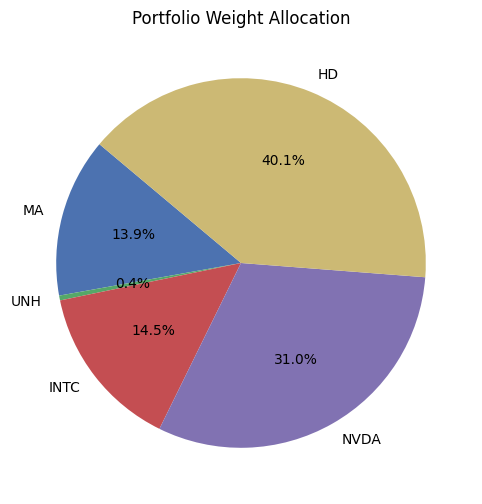

In [ ]:
last_obs = returns.iloc[-env.window_size:].values  # Get the last window_size observations
last_obs = last_obs.reshape(1, env.window_size, returns.shape[1])  # Reshape to (1, window_size, number of assets)
action, _ = model.predict(last_obs)

# Ensure all values in action are non-negative
action[0] = np.abs(action[0])

action = action / np.sum(np.abs(action))  # Normalize the action

plt.figure(figsize=(10, 6))
plt.pie(action[0], labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title('Portfolio Weight Allocation')
plt.show()


*b. Rolling Volatility (6 months) and Rolling Sharpe Ratio*

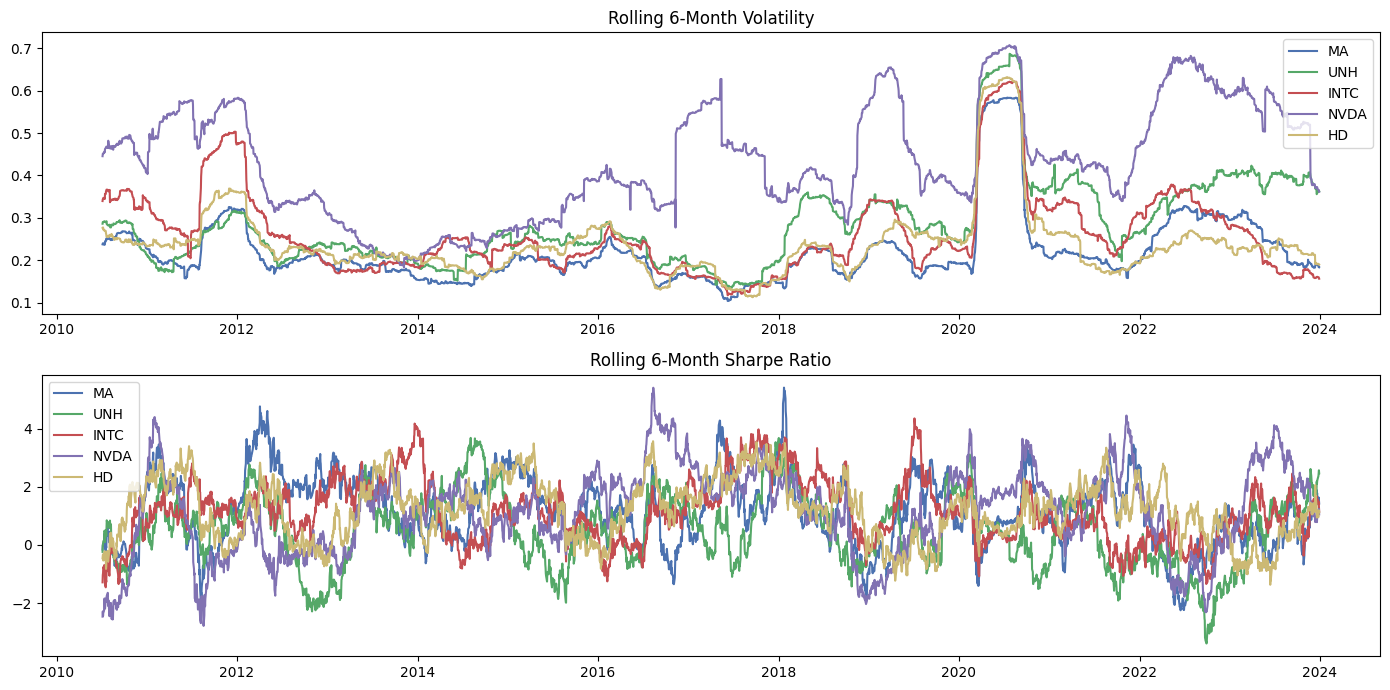

In [ ]:
rolling_window = 126  # 6 months for daily data

rolling_volatility = returns.rolling(rolling_window).std() * np.sqrt(252)
rolling_sharpe = returns.rolling(rolling_window).mean() / returns.rolling(rolling_window).std() * np.sqrt(252)

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(rolling_volatility)
plt.title('Rolling 6-Month Volatility')
plt.legend(tickers)

plt.subplot(2, 1, 2)
plt.plot(rolling_sharpe)
plt.title('Rolling 6-Month Sharpe Ratio')
plt.legend(tickers)

plt.tight_layout()
plt.show()


*c. Accumulative Returns*

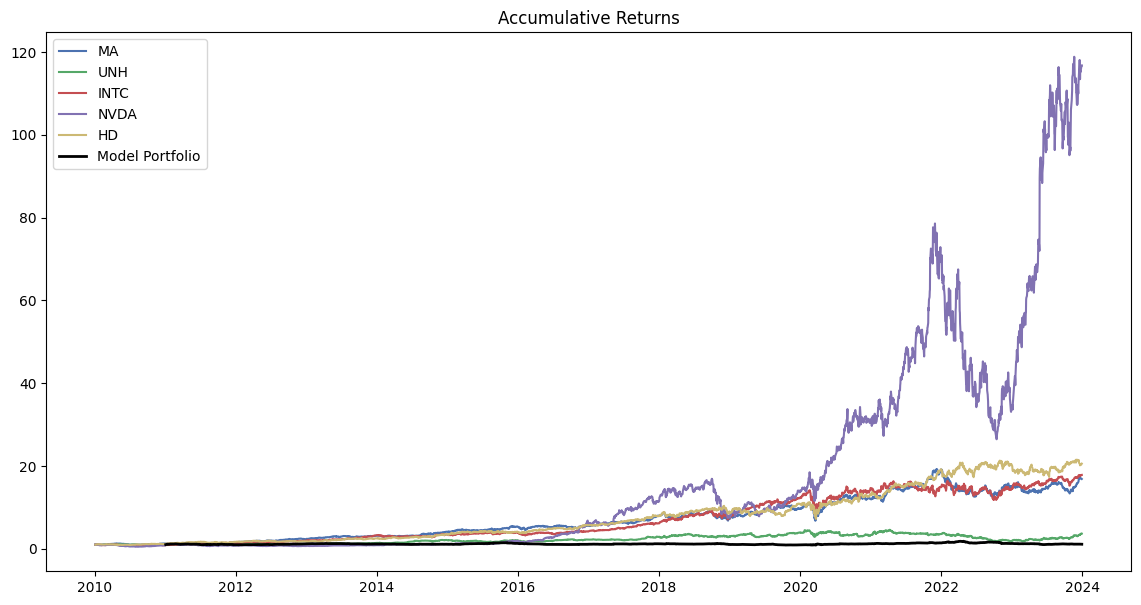

In [ ]:
accumulative_returns = (1 + returns).cumprod()
model_accumulative_returns = pd.Series(portfolio_values, index=returns.index[env.window_size:])

plt.figure(figsize=(14, 7))
plt.plot(accumulative_returns)
plt.plot(model_accumulative_returns, label='Model Portfolio', linewidth=2, color='black')
plt.title('Accumulative Returns')
plt.legend(tickers + ['Model Portfolio'])
plt.show()


*d. Histogram of Returns (Benchmark vs Model)*

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


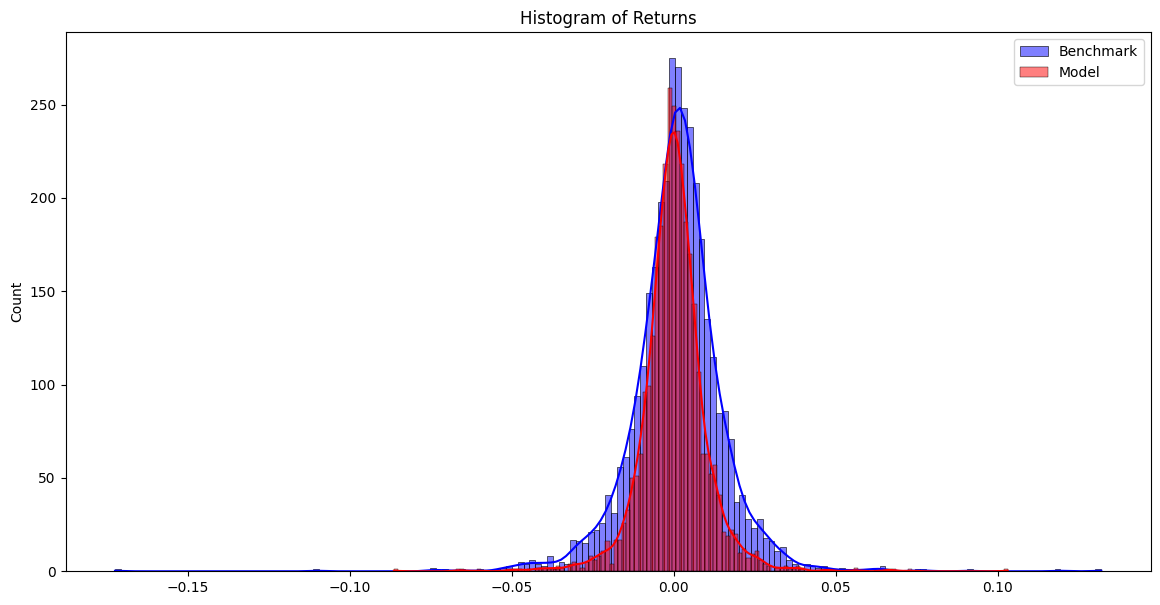

In [ ]:
plt.figure(figsize=(14, 7))
sns.histplot(returns.mean(axis=1), kde=True, label='Benchmark', color='blue')
sns.histplot(model_accumulative_returns.pct_change().dropna(), kde=True, label='Model', color='red')
plt.title('Histogram of Returns')
plt.legend()
plt.show()


*e. Heat Map (Annually Returns)*

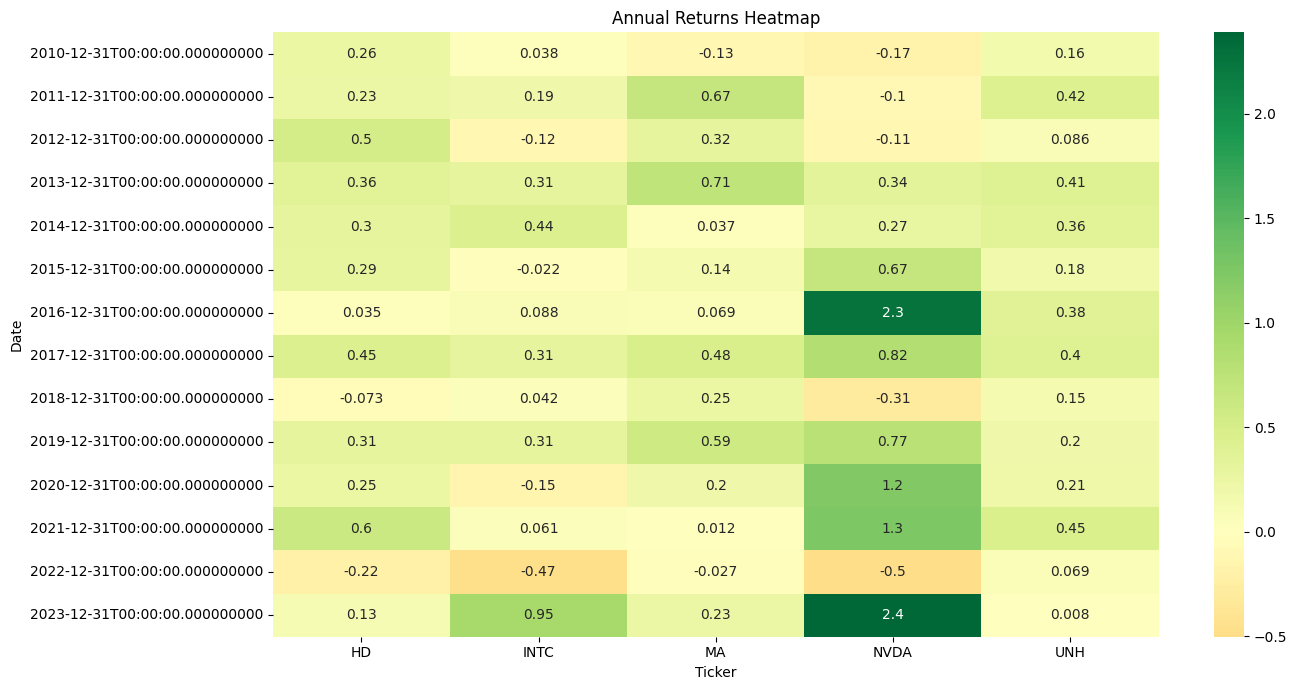

In [ ]:
monthly_returns = returns.resample('Y').agg(lambda x: (1 + x).prod() - 1)
plt.figure(figsize=(14, 7))
sns.heatmap(monthly_returns, annot=True, cmap='RdYlGn', center=0)
plt.title('Annual Returns Heatmap')
plt.tight_layout()
plt.show()


**7. Performance Metrics**

In [ ]:
annualized_return = model_accumulative_returns.resample('Y').last().pct_change().mean()
annualized_volatility = model_accumulative_returns.pct_change().std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

winning_days_ratio = (model_accumulative_returns.pct_change() > 0).mean()

benchmark_returns = returns.mean(axis=1).resample('Y').apply(lambda x: (1 + x).prod() - 1)
information_ratio = (annualized_return - benchmark_returns.mean()) / (annualized_volatility - benchmark_returns.std())

print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Winning Days Ratio: {winning_days_ratio:.2%}")
print(f"Information Ratio: {information_ratio:.2f}")


Annualized Return: 2.10%
Annualized Volatility: 16.32%
Sharpe Ratio: 0.13
Winning Days Ratio: 49.71%
Information Ratio: 3.96
